# Exploiting Hierarchy in Text data

#### Tokens as input features

SHAP estimates feature contributions by perturbing inputs and observing inputs. This involves 'Masking' the feature values. For tabular data this might be replacing a value with the mean, for text this might be replacing the token by '\<MASK\>'.

SHAP also has various methods of exploring the perturbation space:
    
    1) All possible On/Off permutations - Exact Explainer
    2) Subset of On/Off permutations - Permutation Explainer
    3) Heirarchy aware On/Off permutations - Partition Explainer

Since tokens can be treated to similar tabular features, we can use Exact/Permutation explainers to explain text data. Downsides of this approach is that as number of features increases the number of evals required to get a accurate estimate become intractable.

#### Using Hierarchy in text data - Partition Explainer:

We can use the hierarchy of text data to do intelligent perturbation the inputs. Tokens in the text are first converted to a binary tree, partition explainer computes shapley values recursively through the tree hierarchy (this hierarchy defines coalitions and produces Owen values).

Advantages to using partition explainer:
    
    1) SHAP estimates converges faster in partition explainers. Permutation explainer requires atleast 2n + 1 evals to gurantee local accuracy.
    2) Provides more reasonable counterfactual perturbations.


### Loading a sentiment analysis model
Loading BERT a model to perform sentiment analysis on IMDB data. Also truncating the input data to have ~ 100 tokens.

In [9]:
import nlp
import transformers
import pandas as pd
import torch
import numpy as np
import scipy as sp
import shap
import shap.benchmark as benchmark
from tqdm import tqdm

In [10]:
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased", use_fast = True)
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
).cuda()

# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=100, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

imdb_train = nlp.load_dataset("imdb")["train"]['text'][:100]
imdb_train = [review[:300] for review in imdb_train]

#### Creating a Partition explainer

In [11]:
explainer_partition = shap.Explainer(f, tokenizer, algorithm = 'partition')

explainers.Partition is still in an alpha state, so use with caution...


#### Creating a Permutation Explainer

In [4]:
explainer_permutation = shap.Explainer(f, tokenizer, algorithm = 'permutation')

### Sequential Perturbation
Measuring performance between explainers for given number of max_eval = 400

In [5]:
shap_values_parition_fc_none = explainer_partition(imdb_train, max_evals = 400)
shap_values_parition_fc_1 = explainer_partition(imdb_train, fixed_context = 1, max_evals = 400)
shap_values_permutation = explainer_permutation(imdb_train, max_evals = 400)

Partition explainer: 101it [00:26,  2.45it/s]                                                                          
Partition explainer: 101it [00:18,  2.49it/s]                                                                          
Permutation explainer: 101it [00:30,  2.25it/s]                                                                        


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


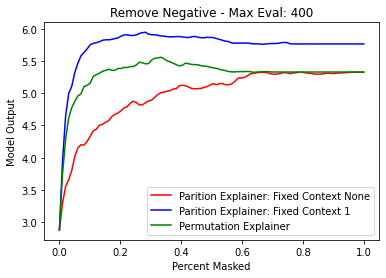

In [6]:
sort_order = 'negative'
perturbation = 'remove'

sequential_perturbation_partition = benchmark.perturbation.SequentialPerturbation(explainer_partition.model, explainer_partition.masker, sort_order, perturbation)
sequential_perturbation_permutation = benchmark.perturbation.SequentialPerturbation(explainer_permutation.model, explainer_permutation.masker, sort_order, perturbation)

xs_partition_fc_none, ys_partition_fc_none, auc_partition_fc_none = sequential_perturbation_partition.model_score(shap_values_parition_fc_none, imdb_train)
xs_partition_fc_1, ys_partition_fc_1, auc_partition_fc_1 = sequential_perturbation_partition.model_score(shap_values_parition_fc_1, imdb_train)
xs_permutation, ys_permutation, auc_permutation = sequential_perturbation_permutation.model_score(shap_values_permutation, imdb_train)

import matplotlib.pyplot as plt
plt.plot(xs_partition_fc_none, ys_partition_fc_none, color='red', label="Parition Explainer: Fixed Context None")
plt.plot(xs_partition_fc_1, ys_partition_fc_1,color='blue', label="Parition Explainer: Fixed Context 1")
plt.plot(xs_permutation, ys_permutation,color='green', label="Permutation Explainer") 
plt.title('Remove Negative - Max Eval: 400')
plt.ylabel("Model Output")
plt.xlabel("Percent Masked")
plt.legend(loc="lower right")
plt.show()

**Observation:** Here we observe that given enough evals the permutation explainer and partition explainer perform similarly.

### Performance vs Max Evals

Here we test the change in performance with increase in max_evals. Here 'performance' is the AUC for Sequential Perturbation Benchmark for a given number of max_evals.

#### Helper Functions

In [7]:
def run_benchmark_permutation(explainer, max_evals, dataset, sequential_perturbation):
    try:
        shap_values = explainer(dataset, max_evals = max_evals)
    except:
        return 0
    xs, ys, auc = sequential_perturbation.model_score(shap_values, dataset)
    return auc

def run_benchmark_partition(explainer, max_evals, dataset, sequential_perturbation, fixed_context = None):
    try:
        shap_values = explainer(dataset, fixed_context = fixed_context, max_evals = max_evals)
    except:
        return 0
    xs, ys, auc = sequential_perturbation.model_score(shap_values, dataset)
    return auc

def plot_comparision_chart(runs_max_evals, runs_permutation_auc, runs_partition_fc_none_auc, runs_partition_fc_1_auc, title = 'Exapliner Comparision'):
    import matplotlib.pyplot as plt
    plt.plot(runs_max_evals, runs_permutation_auc, color='red', label="Permutation Explainer")
    plt.plot(runs_max_evals, runs_partition_fc_none_auc,color='blue', label="Parition Explainer: Fixed Context None")
    plt.plot(runs_max_evals, runs_partition_fc_1_auc,color='blue', label="Parition Explainer: Fixed Context 1")
    plt.ylabel(title)
    plt.ylabel("Run - AUC")
    plt.xlabel("Max Evals")
    plt.legend(loc="lower right")
    plt.show()
    
def run_comparative_benchmark(sort_order, perturbation):
    runs_max_evals = []
    runs_partition_fc_none_auc = []
    runs_partition_fc_1_auc = []
    runs_permutation_auc = []
    
    sequential_perturbation_partition = benchmark.perturbation.SequentialPerturbation(explainer_partition.model, explainer_partition.masker, sort_order, perturbation)
    sequential_perturbation_permutation = benchmark.perturbation.SequentialPerturbation(explainer_permutation.model, explainer_permutation.masker, sort_order, perturbation)
    
    for i in tqdm(range(1, 16)):
        num_evals = i * 25
        
        partition_fc_none_auc = run_benchmark_partition(explainer_partition, num_evals, imdb_train, sequential_perturbation_partition)
        partition_fc_1_auc = run_benchmark_partition(explainer_partition, num_evals, imdb_train, sequential_perturbation_partition, fixed_context = 1)
        permutation_auc = run_benchmark_permutation(explainer_permutation, num_evals, imdb_train, sequential_perturbation_permutation)
        
        runs_max_evals.append(num_evals)
        runs_partition_fc_none_auc.append(partition_fc_none_auc)
        runs_partition_fc_1_auc.append(partition_fc_1_auc)
        runs_permutation_auc.append(permutation_auc)
    
    return runs_max_evals, runs_partition_fc_none_auc, runs_partition_fc_1_auc, runs_permutation_auc

#### Comparing performance of Permutation and Partition Explainer

In [8]:
# running remove negative metric

rn_runs_max_evals = []
rn_runs_permutation_auc = []
rn_runs_partition_fc_none_auc = []
rn_runs_partition_fc_1_auc = []

rn_runs_max_evals, rn_runs_partition_fc_none_auc, rn_runs_partition_fc_1_auc, rn_runs_permutation_auc = run_comparative_benchmark('negative', 'remove')

Partition explainer:  98%|██████████████████████████████████████████████████████████▊ | 98/100 [00:10<00:00, 18.67it/s]
Partition explainer: 101it [00:10,  2.10s/it]                                                                          
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.08it/s]
Partition explainer: 101it [00:11,  1.06it/s]                                                                          

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.31it/s]
Partition explainer: 101it [00:11,  1.42it/s]                                                                          
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.79it/s]
Partition explainer: 101it [00:12,  1.67it/s]                                                                          

Partition explainer: 100%|████████████

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.58it/s]
Partition explainer: 101it [00:15,  2.26it/s]                                                                          

Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.02it/s]
Permutation explainer: 101it [00:16,  2.45it/s]                                                                        
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.35it/s]
Partition explainer: 101it [00:15,  2.35it/s]                                                                          

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.12it/s]
Partition explainer: 101it [00:16,  2.45it/s]                                                                          

Permutation explainer:  76%|█████████

Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.11it/s]
Permutation explainer: 101it [00:16,  2.36it/s]                                                                        
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.90it/s]
Partition explainer: 101it [00:16,  2.44it/s]                                                                          

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.57it/s]
Partition explainer: 101it [00:17,  2.50it/s]                                                                          

Permutation explainer:  83%|████████████████████████████████████████████████▏         | 83/100 [00:14<00:02,  6.19it/s]


Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.96it/s]
Permutation explainer: 101it [00:17,  2.42it/s]                                                                        
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]
Partition explainer: 101it [00:18,  2.52it/s]                                                                          

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.28it/s]
Partition explainer: 101it [00:18,  2.50it/s]                                                                          

Permutation explainer:  71%|█████████████████████████████████████████▏                | 71/100 [00:14<00:05,  5.39it/s]


Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.99it/s]
Permutation explainer: 101it [00:20,  2.56it/s]                                                                        
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.09it/s]
Partition explainer: 101it [00:19,  2.50it/s]                                                                          

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.27it/s]
Partition explainer: 101it [00:18,  2.47it/s]                                                                          

Permutation explainer:  51%|█████████████████████████████▌                            | 51/100 [00:11<00:11,  4.18it/s]


Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.07it/s]
Permutation explainer: 101it [00:23,  2.45it/s]                                                                        
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.73it/s]
Partition explainer: 101it [00:21,  2.52it/s]                                                                          

Partition explainer:  82%|█████████████████████████████████████████████████▏          | 82/100 [00:15<00:03,  5.33it/s]


Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.14it/s]
Partition explainer: 101it [00:18,  2.49it/s]                                                                          

Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.79it/s]
Permutation explainer: 101it [00:25,  2.39it/s]                                                                        
Partition explainer:  96%|█████████████████████████████████████████████████████████▌  | 96/100 [00:21<00:00,  4.48it/s]


Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.46it/s]
Partition explainer: 101it [00:22,  2.50it/s]                                                                          

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.12it/s]
Partition explainer: 101it [00:18,  2.50it/s]                                                                          

Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.68it/s]
Permutation explainer: 101it [00:25,  2.35it/s]                                                                        
Partition explainer:  60%|████████████████████████████████████                        | 60/100 [00:14<00:09,  4.13it/s]


Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.19it/s]
Partition explainer: 101it [00:24,  2.45it/s]                                                                          

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.14it/s]
Partition explainer: 101it [00:18,  2.53it/s]                                                                          

Permutation explainer:  80%|██████████████████████████████████████████████▍           | 80/100 [00:21<00:05,  3.67it/s]


Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.72it/s]
Permutation explainer: 101it [00:27,  2.33it/s]                                                                        
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [11:46<00:00, 47.08s/it]


In [17]:
# running keep positive metric

kp_runs_max_evals = []
kp_runs_permutation_auc = []
kp_runs_partition_fc_none_auc = []
kp_runs_partition_fc_1_auc = []

kp_runs_max_evals, kp_runs_partition_fc_none_auc, kp_runs_partition_fc_1_auc, kp_runs_permutation_auc = run_comparative_benchmark('positive', 'keep')

Partition explainer:  99%|███████████████████████████████████████████████████████████▍| 99/100 [00:10<00:00, 19.03it/s]
Partition explainer: 101it [00:10,  2.60s/it]                                                                          
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.25it/s]
Partition explainer: 101it [00:11,  1.02s/it]                                                                          

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.35it/s]
Partition explainer: 101it [00:11,  1.34it/s]                                                                          
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.82it/s]
Partition explainer: 101it [00:12,  1.67it/s]                                                                          

Partition explainer: 100%|████████████

Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.07it/s]
Permutation explainer: 101it [00:16,  2.37it/s]                                                                        
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.22it/s]
Partition explainer: 101it [00:15,  2.30it/s]                                                                          

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.02it/s]
Partition explainer: 101it [00:16,  2.38it/s]                                                                          

Permutation explainer:  89%|███████████████████████████████████████████████████▌      | 89/100 [00:13<00:01,  7.03it/s]


Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.14it/s]
Permutation explainer: 101it [00:15,  2.38it/s]                                                                        
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.86it/s]
Partition explainer: 101it [00:16,  2.43it/s]                                                                          

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.56it/s]
Partition explainer: 101it [00:17,  2.49it/s]                                                                          

Permutation explainer:  95%|███████████████████████████████████████████████████████   | 95/100 [00:16<00:00,  5.76it/s]


Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  6.07it/s]
Permutation explainer: 101it [00:17,  2.46it/s]                                                                        
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.47it/s]
Partition explainer: 101it [00:18,  2.48it/s]                                                                          

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.33it/s]
Partition explainer: 101it [00:18,  2.51it/s]                                                                          

Permutation explainer:  84%|████████████████████████████████████████████████▋         | 84/100 [00:16<00:03,  4.76it/s]


Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  5.05it/s]
Permutation explainer: 101it [00:20,  2.58it/s]                                                                        
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.05it/s]
Partition explainer: 101it [00:19,  2.50it/s]                                                                          

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.18it/s]
Partition explainer: 101it [00:18,  2.47it/s]                                                                          

Permutation explainer:  65%|█████████████████████████████████████▋                    | 65/100 [00:15<00:08,  4.05it/s]


Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.05it/s]
Permutation explainer: 101it [00:23,  2.42it/s]                                                                        
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.74it/s]
Partition explainer: 101it [00:20,  2.53it/s]                                                                          

Partition explainer:  96%|█████████████████████████████████████████████████████████▌  | 96/100 [00:17<00:00,  5.21it/s]


Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.13it/s]
Partition explainer: 101it [00:18,  2.50it/s]                                                                          

Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  3.85it/s]
Permutation explainer: 101it [00:25,  2.42it/s]                                                                        
Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.43it/s]
Partition explainer: 101it [00:22,  2.50it/s]                                                                          

Partition explainer:  63%|█████████████████████████████████████▊                      | 63/100 [00:11<00:07,  5.03it/s]


Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.14it/s]
Partition explainer: 101it [00:19,  2.47it/s]                                                                          

Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.75it/s]
Permutation explainer: 101it [00:25,  2.37it/s]                                                                        
Partition explainer:  74%|████████████████████████████████████████████▍               | 74/100 [00:17<00:06,  4.17it/s]


Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.12it/s]
Partition explainer: 101it [00:23,  2.46it/s]                                                                          

Partition explainer: 100%|███████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.04it/s]
Partition explainer: 101it [00:19,  2.49it/s]                                                                          

Permutation explainer:  91%|████████████████████████████████████████████████████▊     | 91/100 [00:27<00:02,  3.13it/s]


Permutation explainer: 100%|█████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.53it/s]
Permutation explainer: 101it [00:29,  2.24it/s]                                                                        
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [12:02<00:00, 48.20s/it]


#### Plotting Comparision Charts

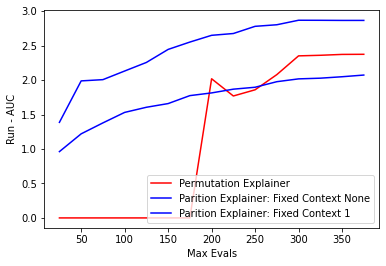

In [19]:
# remove negative
rn_runs_permutation_auc = [-auc for auc in rn_runs_permutation_auc]
rn_runs_partition_fc_none_auc = [-auc for auc in rn_runs_partition_fc_none_auc]
rn_runs_partition_fc_1_auc = [-auc for auc in rn_runs_partition_fc_1_auc]

plot_comparision_chart(rn_runs_max_evals, rn_runs_permutation_auc, rn_runs_partition_fc_none_auc, rn_runs_partition_fc_1_auc, title = 'Explainer Performance - Remove Negative')

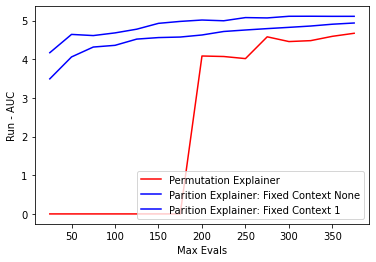

In [18]:
# keep positive
plot_comparision_chart(kp_runs_max_evals, kp_runs_permutation_auc, kp_runs_partition_fc_none_auc, kp_runs_partition_fc_1_auc, title = 'Explainer Performance - Keep Positve')

**Observation:** Here for both the metrics we observe that the Permutation Explainers fails to produce useable results for less 2n+1 Max Evals. Where n is roughly 100  (number of tokens in the input text).
Also we observe that we can produce reasonable results with far fewer evals using the partition explainer. 